# Regularization

## Three types of errors
Every estimator has its advantages and drawbacks. Its generalization error can be decomposed in terms of bias, variance and noise. The **bias** of an estimator is its average error for different training sets. The **variance** of an estimator indicates how sensitive it is to varying training sets. Noise is a property of the data. 

## Underfit vs Overfit

When fit a model to data, it is highly possible that the model is underfit or overfit. 

Roughly speaking, **underfit** means the model is not sufficient to fit the training samples, and **overfit** means that the models learns too many noise from the data. In many cases, high bias is related to underfit, and high variance is related to overfit.

The following example is from [the `sklearn` guide](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py). Although it is a polynomial regression example, it grasps the key idea of underfit and overfit.

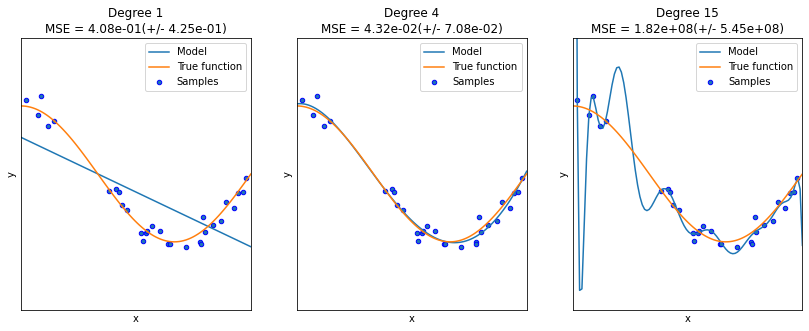

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

## Learning curves (accuracy vs training size)

A learning curve shows the validation and training score of an estimator for varying a key hyperparameter. In most cases the key hyperparameter is the training size or the number of epochs. It is a tool to find out how much we benefit from altering the hyperparameter by training more data or training for more epochs, and whether the estimator suffers more from a variance error or a bias error. 

`sklearn` provides `sklearn.model_selection.learning_curve()` to generate the values that are required to plot such a learning curve. However this function is just related to the sample size. If we would like to talk about epochs, we need other packages.

Let us first look at the learning curve about sample size. The official document page is [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html). The function takes input `estimator`, dataset `X`, `y`, and an arry-like argument `train_sizes`. The dataset `(X, y)` will be split into pieces using the cross-validation technique. The number of pieces is set by the argument `cv`. The default value is `cv=5`. For details about cross-validation please see {numref}`Section %s<section-cross-validation>`.

Then the model is trained over a random sample of the training set, and evaluate the score over the test set. The size of the sample of the training set is set by the argument `train_sizes`. This argument is array-like. Therefore the process will be repeated several times, and we can see the impact of increasing the training size. 

The output contains three pieces. The first is `train_sizes_abs` which is the number of elements in each training set. This output is mainly for reference. The difference between the output and the input `train_sizes` is that the input can be float which represents the percentagy. The output is always the exact number of elements.

The second output is `train_scores` and the third is `test_scores`, both of which are the scores we get from the training and testing process. Note that both are 2D `numpy` arrays, of the size `(number of different sizes, cv)`. Each row is a 1D `numpy` array representing the cross-validation scores, which is corresponding to a train size. If we want the mean as the cross-validation score, we could use `train_scores.mean(axis=1)`.

After understanding the input and output, we could plot the learning curve. We still use the `horse colic` as the example. The details about the dataset can be found in {numref}`Appendix %s<section-dataset-horsecolic>`.

In [2]:
import pandas as pd
import numpy as np

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic/horse-colic.data'
df = pd.read_csv(url, delim_whitespace=True, header=None)
df = df.replace("?", np.NaN)

df.fillna(0, inplace=True)
df.drop(columns=[2, 24, 25, 26, 27], inplace=True)
df[23].replace({1: 1, 2: 0}, inplace=True)
X = df.iloc[:, :-1].to_numpy().astype(float)
y = df[23].to_numpy().astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

We use the model `LogisticRegression`. The following code plot the learning curve for this model.

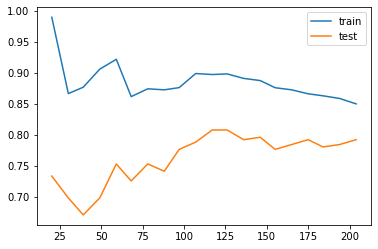

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

clf = LogisticRegression(max_iter=1000)
steps = [('scalar', MinMaxScaler()),
         ('log', clf)]
pipe = Pipeline(steps=steps)
from sklearn.model_selection import learning_curve
import numpy as np
train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train,
                                                        train_sizes=np.linspace(0.1, 1, 20))

import matplotlib.pyplot as plt
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='test')
plt.legend()

The learning curve is a primary tool for us to study the bias and variance. Usually

- If the two training curve and the testing curve are very close to each other, this means that the variance is low. Otherwise the variance is high, and this means that the model probabily suffer from overfitting. 
- If the absolute training curve score is high, this means that the bias is low. Otherwise the bias is high, and this means that the model probabily suffer from underfitting.

In the above example, although regularization is applied by default, you may still notice some overfitting there.

## Regularization
Regularization is a technique to deal with overfitting. Here we only talk about the simplest method: ridge regression, also known as Tikhonov regularizaiton. Because of the formula given below, it is also called *$L_2$ regularization*. The idea is to add an additional term $\dfrac{\alpha}{2m}\sum_{i=1}^m\theta_i^2$ to the original cost function. When training with the new cost function, this additional term will force the parameters in the original term to be as small as possible. After finishing training, the additional term will be dropped, and we use the original cost function for validation and testing. Note that in the additional term $\theta_0$ is not presented.

The hyperparameter $\alpha$ is the *regularization strength*. If $\alpha=0$, the new cost function becomes the original one; If $\alpha$ is very large, the additional term dominates, and it will force all parameters to be almost $0$. In different context, the regularization strength is also given by $C=\dfrac{1}{2\alpha}$, called *inverse of regularization strength*.


### The math of regularization


```{prf:theorem}
The gradient of the ridge regression cost function is

$$
\nabla J=\frac1m(\textbf{p}-\textbf{y})^T\hat{\textbf{X}}+\frac{\alpha}{m}\Theta.
$$

Note that $\Theta$ doesn't contain $\theta_0$, or you may treat $\theta_0=0$.
```

The computation is straightforward.

### The code

Regularization is directly provided by the logistic regression functions.

- In `LogisticRegression`, the regularization is given by the argument `penalty` and `C`. `penalty` specifies the regularizaiton method. It is `l2` by default, which is the method above. `C` is the inverse of regularization strength, whose default value is `1`.
- In `SGDClassifier`, the regularization is given by the argument `penalty` and `alpha`. `penalty` is the same as that in `LogisticRegression`, and `alpha` is the regularization strength, whose default value is `0.0001`.

Let us see the above example.

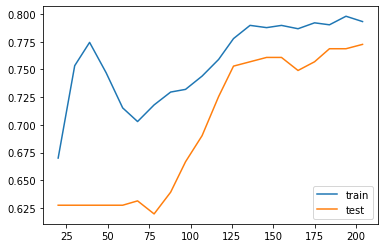

In [4]:

clf = LogisticRegression(max_iter=1000, C=0.1)
steps = [('scalar', MinMaxScaler()),
         ('log', clf)]
pipe = Pipeline(steps=steps)
from sklearn.model_selection import learning_curve
import numpy as np
train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train,
                                                        train_sizes=np.linspace(0.1, 1, 20))

import matplotlib.pyplot as plt
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='test')
plt.legend()

After we reduce `C` from `1` to `0.1`, the regularization strength is increased. Then you may find that the gap between the two curves are reduced. However the overall performace is also reduced, from 85%~90% in `C=1` case to around 80% in `C=0.1` case. This means that the model doesn't fit the data well as the previous one. Therefore this is a trade-off: decrease the variance but increase the bias.